In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, 2.0, 2.0)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.norm0 = nn.BatchNorm2d(num_features=64)        
        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.norm0(self.conv0(x)))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = self.conv1(cloud_phase_pred)
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred

In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3_1().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Epoch: 1 | Train Loss: 20.5870 | Val Loss: 16.9711 | Val Mask: 0.5394 | Val Phase: 0.5727 | Val Cod: -0.3362 | Val Cps: -1.5520


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 2 | Train Loss: 15.1054 | Val Loss: 13.1053 | Val Mask: 0.4769 | Val Phase: 0.6972 | Val Cod: 0.0834 | Val Cps: -0.9658


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 3 | Train Loss: 11.5839 | Val Loss: 9.5770 | Val Mask: 0.4410 | Val Phase: 0.7570 | Val Cod: 0.3760 | Val Cps: -0.3993


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 4 | Train Loss: 8.1091 | Val Loss: 6.8130 | Val Mask: 0.4680 | Val Phase: 0.7774 | Val Cod: 0.4694 | Val Cps: 0.1081


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 5 | Train Loss: 5.5866 | Val Loss: 4.9745 | Val Mask: 0.6545 | Val Phase: 0.8038 | Val Cod: 0.5537 | Val Cps: 0.4141


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 6 | Train Loss: 4.1983 | Val Loss: 3.8952 | Val Mask: 0.8220 | Val Phase: 0.8184 | Val Cod: 0.6198 | Val Cps: 0.5694


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 7 | Train Loss: 3.6520 | Val Loss: 3.5082 | Val Mask: 0.8829 | Val Phase: 0.8191 | Val Cod: 0.6341 | Val Cps: 0.6178


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 8 | Train Loss: 3.2947 | Val Loss: 3.3048 | Val Mask: 0.9029 | Val Phase: 0.8324 | Val Cod: 0.6379 | Val Cps: 0.6406


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 9 | Train Loss: 3.1108 | Val Loss: 3.3220 | Val Mask: 0.9094 | Val Phase: 0.8210 | Val Cod: 0.6613 | Val Cps: 0.6178


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 10 | Train Loss: 2.9648 | Val Loss: 2.9677 | Val Mask: 0.9238 | Val Phase: 0.8388 | Val Cod: 0.6727 | Val Cps: 0.6724


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 11 | Train Loss: 2.8367 | Val Loss: 2.8597 | Val Mask: 0.9314 | Val Phase: 0.8406 | Val Cod: 0.6768 | Val Cps: 0.6854


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 12 | Train Loss: 2.7322 | Val Loss: 2.8464 | Val Mask: 0.9345 | Val Phase: 0.8425 | Val Cod: 0.6828 | Val Cps: 0.6808


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 13 | Train Loss: 2.6658 | Val Loss: 2.7473 | Val Mask: 0.9396 | Val Phase: 0.8461 | Val Cod: 0.6920 | Val Cps: 0.6916


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 14 | Train Loss: 2.5778 | Val Loss: 2.7521 | Val Mask: 0.9417 | Val Phase: 0.8466 | Val Cod: 0.6923 | Val Cps: 0.6867


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 15 | Train Loss: 2.5314 | Val Loss: 2.6482 | Val Mask: 0.9432 | Val Phase: 0.8502 | Val Cod: 0.6974 | Val Cps: 0.7031


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 16 | Train Loss: 2.4507 | Val Loss: 2.6136 | Val Mask: 0.9439 | Val Phase: 0.8523 | Val Cod: 0.6952 | Val Cps: 0.7085


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 17 | Train Loss: 2.4142 | Val Loss: 2.5808 | Val Mask: 0.9454 | Val Phase: 0.8513 | Val Cod: 0.6981 | Val Cps: 0.7128


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 18 | Train Loss: 2.3836 | Val Loss: 2.5519 | Val Mask: 0.9458 | Val Phase: 0.8539 | Val Cod: 0.7053 | Val Cps: 0.7143


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 19 | Train Loss: 2.3244 | Val Loss: 2.4991 | Val Mask: 0.9478 | Val Phase: 0.8558 | Val Cod: 0.7096 | Val Cps: 0.7199


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 20 | Train Loss: 2.2872 | Val Loss: 2.4816 | Val Mask: 0.9483 | Val Phase: 0.8554 | Val Cod: 0.7118 | Val Cps: 0.7220


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 21 | Train Loss: 2.2584 | Val Loss: 2.4559 | Val Mask: 0.9500 | Val Phase: 0.8542 | Val Cod: 0.7133 | Val Cps: 0.7251


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 22 | Train Loss: 2.2277 | Val Loss: 2.4303 | Val Mask: 0.9508 | Val Phase: 0.8574 | Val Cod: 0.7155 | Val Cps: 0.7271


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 23 | Train Loss: 2.1951 | Val Loss: 2.4811 | Val Mask: 0.9488 | Val Phase: 0.8623 | Val Cod: 0.7170 | Val Cps: 0.7137


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 24 | Train Loss: 2.1675 | Val Loss: 2.3985 | Val Mask: 0.9515 | Val Phase: 0.8622 | Val Cod: 0.7212 | Val Cps: 0.7267


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch: 25 | Train Loss: 2.1380 | Val Loss: 2.3827 | Val Mask: 0.9497 | Val Phase: 0.8606 | Val Cod: 0.7216 | Val Cps: 0.7316


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 26 | Train Loss: 2.1092 | Val Loss: 2.3694 | Val Mask: 0.9532 | Val Phase: 0.8617 | Val Cod: 0.7243 | Val Cps: 0.7313


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 27 | Train Loss: 2.0817 | Val Loss: 2.3924 | Val Mask: 0.9541 | Val Phase: 0.8561 | Val Cod: 0.7250 | Val Cps: 0.7286


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 28 | Train Loss: 2.0641 | Val Loss: 2.3621 | Val Mask: 0.9526 | Val Phase: 0.8607 | Val Cod: 0.7229 | Val Cps: 0.7337


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 29 | Train Loss: 2.0336 | Val Loss: 2.2855 | Val Mask: 0.9558 | Val Phase: 0.8624 | Val Cod: 0.7296 | Val Cps: 0.7429


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 30 | Train Loss: 2.0419 | Val Loss: 2.3257 | Val Mask: 0.9554 | Val Phase: 0.8669 | Val Cod: 0.7293 | Val Cps: 0.7331


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 31 | Train Loss: 2.0550 | Val Loss: 2.4373 | Val Mask: 0.9537 | Val Phase: 0.8655 | Val Cod: 0.7220 | Val Cps: 0.7127


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 32 | Train Loss: 2.0817 | Val Loss: 2.2965 | Val Mask: 0.9550 | Val Phase: 0.8683 | Val Cod: 0.7313 | Val Cps: 0.7372


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 33 | Train Loss: 1.9810 | Val Loss: 2.2632 | Val Mask: 0.9575 | Val Phase: 0.8662 | Val Cod: 0.7357 | Val Cps: 0.7419


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 34 | Train Loss: 1.9517 | Val Loss: 2.2416 | Val Mask: 0.9572 | Val Phase: 0.8670 | Val Cod: 0.7355 | Val Cps: 0.7457


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 35 | Train Loss: 1.9364 | Val Loss: 2.2361 | Val Mask: 0.9572 | Val Phase: 0.8687 | Val Cod: 0.7332 | Val Cps: 0.7471


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 36 | Train Loss: 1.9261 | Val Loss: 2.2192 | Val Mask: 0.9572 | Val Phase: 0.8704 | Val Cod: 0.7372 | Val Cps: 0.7480


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 37 | Train Loss: 1.8930 | Val Loss: 2.2150 | Val Mask: 0.9584 | Val Phase: 0.8696 | Val Cod: 0.7392 | Val Cps: 0.7472


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 38 | Train Loss: 1.8733 | Val Loss: 2.2382 | Val Mask: 0.9591 | Val Phase: 0.8691 | Val Cod: 0.7366 | Val Cps: 0.7435


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 39 | Train Loss: 1.8650 | Val Loss: 2.2009 | Val Mask: 0.9592 | Val Phase: 0.8709 | Val Cod: 0.7407 | Val Cps: 0.7479


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 40 | Train Loss: 1.8439 | Val Loss: 2.2555 | Val Mask: 0.9593 | Val Phase: 0.8627 | Val Cod: 0.7381 | Val Cps: 0.7420


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 41 | Train Loss: 1.8477 | Val Loss: 2.2043 | Val Mask: 0.9595 | Val Phase: 0.8682 | Val Cod: 0.7431 | Val Cps: 0.7473


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 42 | Train Loss: 1.8357 | Val Loss: 2.1614 | Val Mask: 0.9606 | Val Phase: 0.8713 | Val Cod: 0.7436 | Val Cps: 0.7539


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 43 | Train Loss: 1.8203 | Val Loss: 2.1490 | Val Mask: 0.9608 | Val Phase: 0.8745 | Val Cod: 0.7456 | Val Cps: 0.7537


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 44 | Train Loss: 1.8077 | Val Loss: 2.1646 | Val Mask: 0.9609 | Val Phase: 0.8724 | Val Cod: 0.7440 | Val Cps: 0.7517


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 45 | Train Loss: 1.7953 | Val Loss: 2.1441 | Val Mask: 0.9613 | Val Phase: 0.8739 | Val Cod: 0.7438 | Val Cps: 0.7552


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 46 | Train Loss: 1.7781 | Val Loss: 2.1421 | Val Mask: 0.9618 | Val Phase: 0.8740 | Val Cod: 0.7488 | Val Cps: 0.7539


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 47 | Train Loss: 1.7671 | Val Loss: 2.1345 | Val Mask: 0.9618 | Val Phase: 0.8743 | Val Cod: 0.7470 | Val Cps: 0.7567


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 48 | Train Loss: 1.7469 | Val Loss: 2.1310 | Val Mask: 0.9617 | Val Phase: 0.8753 | Val Cod: 0.7464 | Val Cps: 0.7575


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 49 | Train Loss: 1.7371 | Val Loss: 2.1613 | Val Mask: 0.9624 | Val Phase: 0.8723 | Val Cod: 0.7489 | Val Cps: 0.7497


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 50 | Train Loss: 1.7496 | Val Loss: 2.1841 | Val Mask: 0.9620 | Val Phase: 0.8665 | Val Cod: 0.7457 | Val Cps: 0.7498


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 51 | Train Loss: 1.7404 | Val Loss: 2.1249 | Val Mask: 0.9625 | Val Phase: 0.8715 | Val Cod: 0.7493 | Val Cps: 0.7572


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 52 | Train Loss: 1.7394 | Val Loss: 2.1199 | Val Mask: 0.9625 | Val Phase: 0.8718 | Val Cod: 0.7500 | Val Cps: 0.7605


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 53 | Train Loss: 1.7202 | Val Loss: 2.1059 | Val Mask: 0.9625 | Val Phase: 0.8762 | Val Cod: 0.7512 | Val Cps: 0.7589


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 54 | Train Loss: 1.7169 | Val Loss: 2.1542 | Val Mask: 0.9620 | Val Phase: 0.8750 | Val Cod: 0.7520 | Val Cps: 0.7499


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 55 | Train Loss: 1.7141 | Val Loss: 2.1399 | Val Mask: 0.9633 | Val Phase: 0.8740 | Val Cod: 0.7476 | Val Cps: 0.7530


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 56 | Train Loss: 1.6905 | Val Loss: 2.0947 | Val Mask: 0.9628 | Val Phase: 0.8749 | Val Cod: 0.7511 | Val Cps: 0.7621


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 57 | Train Loss: 1.6774 | Val Loss: 2.0928 | Val Mask: 0.9631 | Val Phase: 0.8749 | Val Cod: 0.7525 | Val Cps: 0.7621


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 58 | Train Loss: 1.6508 | Val Loss: 2.0599 | Val Mask: 0.9643 | Val Phase: 0.8790 | Val Cod: 0.7571 | Val Cps: 0.7625


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 59 | Train Loss: 1.6582 | Val Loss: 2.1014 | Val Mask: 0.9647 | Val Phase: 0.8757 | Val Cod: 0.7559 | Val Cps: 0.7557


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 60 | Train Loss: 1.6577 | Val Loss: 2.0623 | Val Mask: 0.9637 | Val Phase: 0.8784 | Val Cod: 0.7559 | Val Cps: 0.7637


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 61 | Train Loss: 1.6433 | Val Loss: 2.0983 | Val Mask: 0.9641 | Val Phase: 0.8744 | Val Cod: 0.7557 | Val Cps: 0.7580


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 62 | Train Loss: 1.6282 | Val Loss: 2.0553 | Val Mask: 0.9645 | Val Phase: 0.8798 | Val Cod: 0.7571 | Val Cps: 0.7639


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 63 | Train Loss: 1.6359 | Val Loss: 2.0697 | Val Mask: 0.9639 | Val Phase: 0.8753 | Val Cod: 0.7545 | Val Cps: 0.7638


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 64 | Train Loss: 1.6243 | Val Loss: 2.0484 | Val Mask: 0.9645 | Val Phase: 0.8777 | Val Cod: 0.7563 | Val Cps: 0.7660


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 65 | Train Loss: 1.6326 | Val Loss: 2.0896 | Val Mask: 0.9639 | Val Phase: 0.8742 | Val Cod: 0.7541 | Val Cps: 0.7603


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 66 | Train Loss: 1.6169 | Val Loss: 2.0755 | Val Mask: 0.9646 | Val Phase: 0.8775 | Val Cod: 0.7567 | Val Cps: 0.7623


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 67 | Train Loss: 1.6021 | Val Loss: 2.0343 | Val Mask: 0.9646 | Val Phase: 0.8801 | Val Cod: 0.7594 | Val Cps: 0.7675


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 68 | Train Loss: 1.6054 | Val Loss: 2.0508 | Val Mask: 0.9651 | Val Phase: 0.8786 | Val Cod: 0.7580 | Val Cps: 0.7635


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 69 | Train Loss: 1.5846 | Val Loss: 2.0704 | Val Mask: 0.9653 | Val Phase: 0.8743 | Val Cod: 0.7605 | Val Cps: 0.7608


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 70 | Train Loss: 1.5808 | Val Loss: 2.0252 | Val Mask: 0.9655 | Val Phase: 0.8813 | Val Cod: 0.7611 | Val Cps: 0.7662


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 71 | Train Loss: 1.5803 | Val Loss: 2.0231 | Val Mask: 0.9652 | Val Phase: 0.8820 | Val Cod: 0.7607 | Val Cps: 0.7673


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 72 | Train Loss: 1.5652 | Val Loss: 2.0166 | Val Mask: 0.9654 | Val Phase: 0.8798 | Val Cod: 0.7615 | Val Cps: 0.7688


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 73 | Train Loss: 1.5653 | Val Loss: 2.0396 | Val Mask: 0.9646 | Val Phase: 0.8801 | Val Cod: 0.7612 | Val Cps: 0.7646


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 74 | Train Loss: 1.5774 | Val Loss: 2.0055 | Val Mask: 0.9653 | Val Phase: 0.8830 | Val Cod: 0.7624 | Val Cps: 0.7698


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 75 | Train Loss: 1.5570 | Val Loss: 2.2061 | Val Mask: 0.9640 | Val Phase: 0.8720 | Val Cod: 0.7562 | Val Cps: 0.7418


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 76 | Train Loss: 1.5557 | Val Loss: 1.9987 | Val Mask: 0.9662 | Val Phase: 0.8831 | Val Cod: 0.7627 | Val Cps: 0.7699


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 77 | Train Loss: 1.5432 | Val Loss: 2.0183 | Val Mask: 0.9662 | Val Phase: 0.8798 | Val Cod: 0.7609 | Val Cps: 0.7684


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 78 | Train Loss: 1.5378 | Val Loss: 2.0154 | Val Mask: 0.9658 | Val Phase: 0.8807 | Val Cod: 0.7619 | Val Cps: 0.7696


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 79 | Train Loss: 1.5312 | Val Loss: 2.0652 | Val Mask: 0.9661 | Val Phase: 0.8767 | Val Cod: 0.7602 | Val Cps: 0.7599


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 80 | Train Loss: 1.5184 | Val Loss: 2.0050 | Val Mask: 0.9664 | Val Phase: 0.8824 | Val Cod: 0.7629 | Val Cps: 0.7688


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 81 | Train Loss: 1.5126 | Val Loss: 2.0402 | Val Mask: 0.9661 | Val Phase: 0.8812 | Val Cod: 0.7635 | Val Cps: 0.7637


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 82 | Train Loss: 1.5079 | Val Loss: 2.0104 | Val Mask: 0.9662 | Val Phase: 0.8802 | Val Cod: 0.7648 | Val Cps: 0.7698


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 83 | Train Loss: 1.5005 | Val Loss: 2.0100 | Val Mask: 0.9667 | Val Phase: 0.8826 | Val Cod: 0.7652 | Val Cps: 0.7663


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 84 | Train Loss: 1.5001 | Val Loss: 2.0178 | Val Mask: 0.9658 | Val Phase: 0.8808 | Val Cod: 0.7627 | Val Cps: 0.7672


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 85 | Train Loss: 1.5014 | Val Loss: 2.0305 | Val Mask: 0.9666 | Val Phase: 0.8793 | Val Cod: 0.7653 | Val Cps: 0.7639


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 86 | Train Loss: 1.4938 | Val Loss: 2.0120 | Val Mask: 0.9663 | Val Phase: 0.8810 | Val Cod: 0.7609 | Val Cps: 0.7716


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 87 | Train Loss: 1.4951 | Val Loss: 1.9895 | Val Mask: 0.9669 | Val Phase: 0.8832 | Val Cod: 0.7658 | Val Cps: 0.7707


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 88 | Train Loss: 1.4844 | Val Loss: 2.0580 | Val Mask: 0.9659 | Val Phase: 0.8789 | Val Cod: 0.7639 | Val Cps: 0.7630


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 89 | Train Loss: 1.4903 | Val Loss: 2.0376 | Val Mask: 0.9668 | Val Phase: 0.8756 | Val Cod: 0.7638 | Val Cps: 0.7650


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 90 | Train Loss: 1.4750 | Val Loss: 2.0211 | Val Mask: 0.9668 | Val Phase: 0.8753 | Val Cod: 0.7646 | Val Cps: 0.7682


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 91 | Train Loss: 1.4675 | Val Loss: 2.0474 | Val Mask: 0.9656 | Val Phase: 0.8778 | Val Cod: 0.7563 | Val Cps: 0.7666


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 92 | Train Loss: 1.4669 | Val Loss: 2.0192 | Val Mask: 0.9668 | Val Phase: 0.8801 | Val Cod: 0.7651 | Val Cps: 0.7696


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 93 | Train Loss: 1.4634 | Val Loss: 1.9779 | Val Mask: 0.9675 | Val Phase: 0.8835 | Val Cod: 0.7659 | Val Cps: 0.7735


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 94 | Train Loss: 1.4539 | Val Loss: 2.0019 | Val Mask: 0.9667 | Val Phase: 0.8819 | Val Cod: 0.7613 | Val Cps: 0.7737


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 95 | Train Loss: 1.4586 | Val Loss: 1.9925 | Val Mask: 0.9670 | Val Phase: 0.8842 | Val Cod: 0.7675 | Val Cps: 0.7688


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 96 | Train Loss: 1.4491 | Val Loss: 1.9793 | Val Mask: 0.9672 | Val Phase: 0.8845 | Val Cod: 0.7669 | Val Cps: 0.7734


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 97 | Train Loss: 1.4466 | Val Loss: 2.0190 | Val Mask: 0.9672 | Val Phase: 0.8793 | Val Cod: 0.7667 | Val Cps: 0.7701


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 98 | Train Loss: 1.4415 | Val Loss: 1.9694 | Val Mask: 0.9680 | Val Phase: 0.8833 | Val Cod: 0.7688 | Val Cps: 0.7725


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 99 | Train Loss: 1.4400 | Val Loss: 1.9640 | Val Mask: 0.9667 | Val Phase: 0.8846 | Val Cod: 0.7683 | Val Cps: 0.7757


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 100 | Train Loss: 1.4341 | Val Loss: 1.9751 | Val Mask: 0.9675 | Val Phase: 0.8839 | Val Cod: 0.7673 | Val Cps: 0.7732


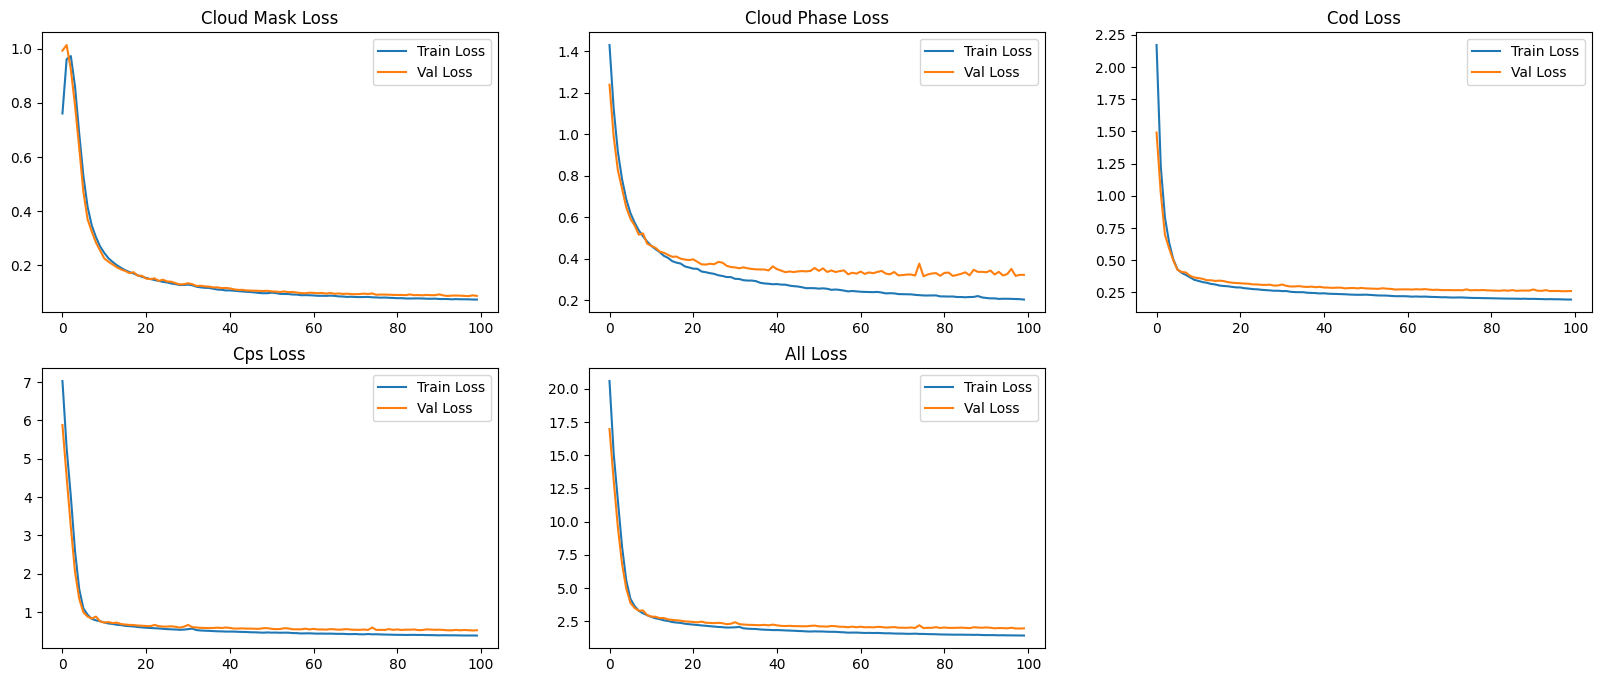

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.3_loss.png")  

plt.show()

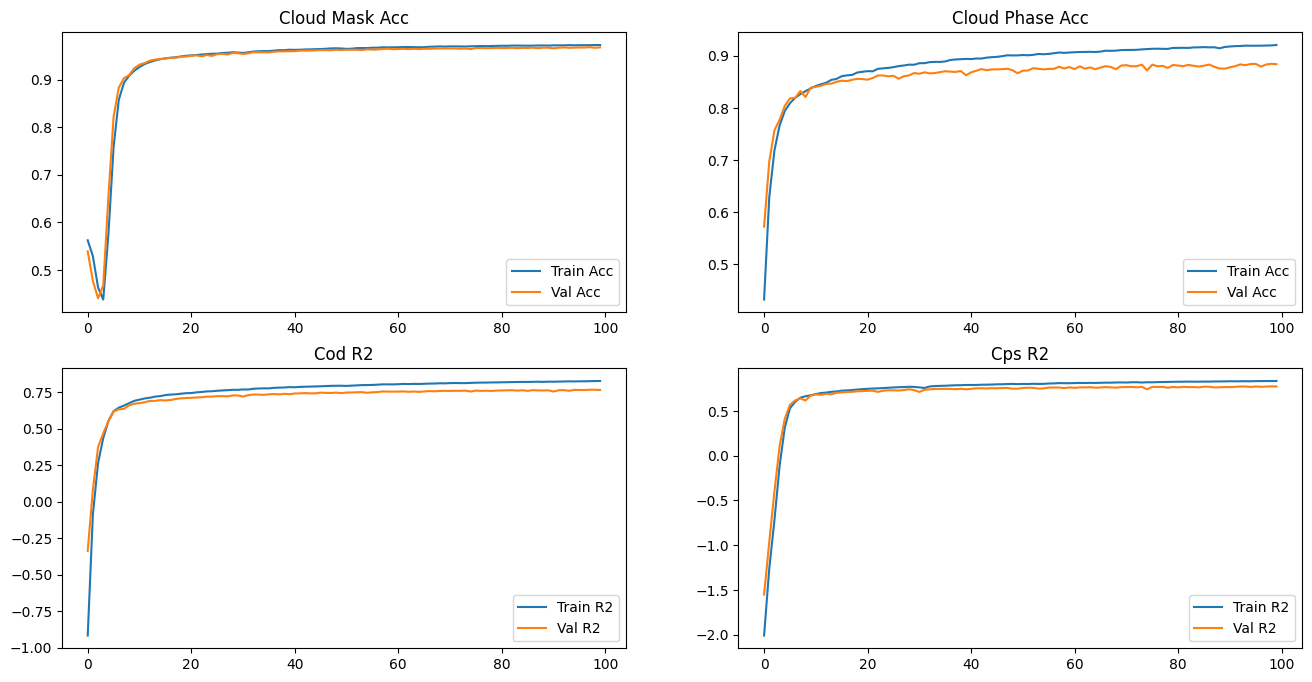

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.3_acc.png")  

plt.show()


In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.941     0.904     0.922   5803166
           1      0.971     0.982     0.977  18740066

    accuracy                          0.964  24543232
   macro avg      0.956     0.943     0.949  24543232
weighted avg      0.964     0.964     0.964  24543232

CONFUSION MATRIX:
 [[ 5247714   555452]
 [  329403 18410663]]

IOU: [0.85571218 0.95414194]
Unweighted IoU: 0.9049270615537812
Weighted IoU: 0.9308685502639242


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  7.09it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.911     0.874     0.892   4373397
           1      0.891     0.926     0.908  10864796
           2      0.778     0.850     0.813   2400565
           3      0.541     0.501     0.520    890044
           4      0.921     0.860     0.889   6014430

    accuracy                          0.878  24543232
   macro avg      0.809     0.802     0.805  24543232
weighted avg      0.878     0.878     0.877  24543232

CONFUSION MATRIX:
 [[ 3823947   491112    16416     4019    37903]
 [  318486 10055374   237160    28540   225236]
 [    2959   188715  2040835   131053    37003]
 [     919    48720   249274   445558   145573]
 [   50979   497384    78715   213667  5173685]]

IOU: [0.80559437 0.83166    0.68435481 0.35157414 0.80086205]
Unweighted IoU: 0.6948090742099998
Weighted IoU: 0.7876502831039323


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.18it/s]


r2: 0.7651379108428955
MSE: 0.27038338780403137


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.19it/s]


r2: 0.7753934860229492
MSE: 0.5395858883857727


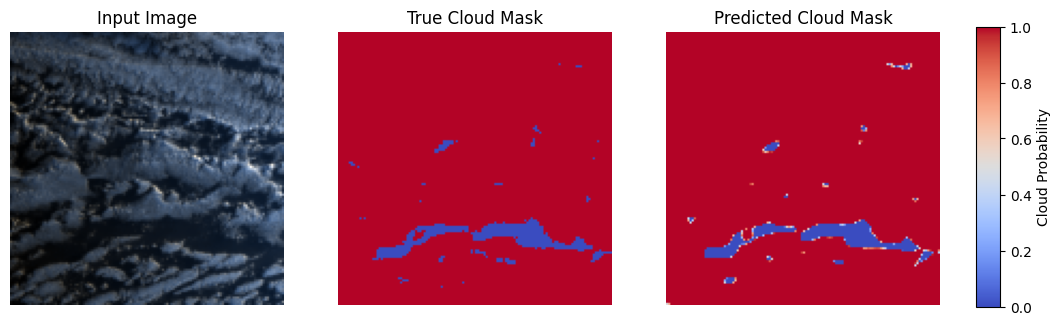

In [45]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

# Get the first batch (skip 4 batches)
iterator = iter(test_loader)
images, labels = next(iterator)

# Move to device
images = images.to(device)
labels = labels.to(device)

# Unpack cloud phase
cloud_mask_target, _, _, _ = unpack_labels(labels)
cloud_mask_pred, _, _, _ = model(images)

# Get predictions
#preds = torch.argmax(cloud_mask_pred, dim=1)

# Get first sample
idx = 2
img = images[idx].cpu().permute(1, 2, 0)  # (H, W, C)
true_mask = cloud_mask_target[idx].cpu().squeeze().numpy()
pred_mask = cloud_mask_pred[idx].cpu().squeeze().detach().numpy()

# Extract ABI bands
blue = normalize(img[:, :, 0])  # Band 1
red = normalize(img[:, :, 1])   # Band 2
nir = normalize(img[:, :, 2])   # Band 3

# Simulate green using weighted combo
sim_green = (0.45 * red + 0.10 * nir + 0.45 * blue)
rgb_norm = torch.stack([red, sim_green, blue], dim=2).numpy()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(rgb_norm)
axs[0].set_title("Input Image")
axs[0].axis('off')

im1 = axs[1].imshow(true_mask, cmap='coolwarm', vmin=0, vmax=1)
axs[1].set_title("True Cloud Mask")
axs[1].axis('off')

im2 = axs[2].imshow(pred_mask, cmap='coolwarm', vmin=0, vmax=1)
axs[2].set_title("Predicted Cloud Mask")
axs[2].axis('off')

# Add colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Cloud Probability')

plt.subplots_adjust(right=0.9)
plt.show()


In [16]:
import numpy as np
from PIL import Image

# Convert from float tensor [0, 1] → uint8 [0, 255]
rgb_uint8 = (rgb_norm * 255).astype(np.uint8)  # Shape: (H, W, 3)

# Save as high-resolution image
Image.fromarray(rgb_uint8).save("./maps/satellite_image.png", dpi=(300, 300))


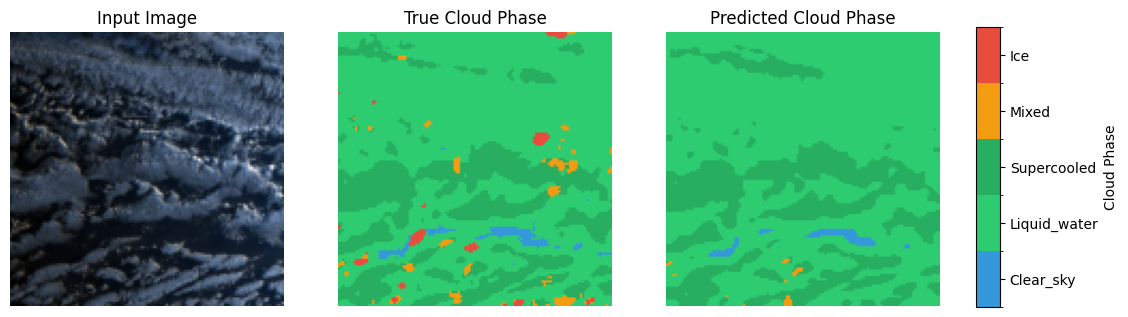

In [37]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

# Get the first batch
iterator = iter(test_loader)
images, labels = next(iterator)

# Move to device
images = images.to(device)
labels = labels.to(device)

# Unpack cloud phase
_, cloud_phase_target, _, _ = unpack_labels(labels)
_, cloud_phase_pred, _, _ = model(images)

# Get predictions
preds = torch.argmax(cloud_phase_pred, dim=1)

# Get first sample
img = images[idx].cpu().permute(1, 2, 0)
true_label = cloud_phase_target[idx].cpu().numpy()
pred_label = preds[idx].cpu().numpy()

# Extract ABI bands
blue = normalize(img[:, :, 0])  # Band 1
red = normalize(img[:, :, 1])   # Band 2
nir = normalize(img[:, :, 2])   # Band 3

# Simulate green using weighted combo (approx. true-color)
sim_green = (0.45 * red + 0.10 * nir + 0.45 * blue)
rgb_norm = torch.stack([red, sim_green, blue], dim=2).numpy()
#rgb_norm = torch.stack([red, nir, blue], dim=2).numpy()



# Define custom colormap and norm for discrete classes
phase_colors = ['#3498db', '#2ecc71', '#27ae60', '#f39c12', '#e74c3c']
custom_cmap = ListedColormap(phase_colors)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, custom_cmap.N)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(rgb_norm)
axs[0].set_title("Input Image")
axs[0].axis('off')

im = axs[1].imshow(true_label, cmap=custom_cmap, norm=norm)
axs[1].set_title("True Cloud Phase")
axs[1].axis('off')

axs[2].imshow(pred_label, cmap=custom_cmap, norm=norm)
axs[2].set_title("Predicted Cloud Phase")
axs[2].axis('off')

# Add discrete colorbar on the right without shrinking images
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(im, cax=cbar_ax, boundaries=bounds, ticks=[0,1,2,3,4], orientation='vertical')
cbar.ax.set_yticklabels(['Clear_sky', 'Liquid_water', 'Supercooled', 'Mixed', 'Ice'])
cbar.set_label('Cloud Phase')

plt.subplots_adjust(right=0.9)
plt.show()


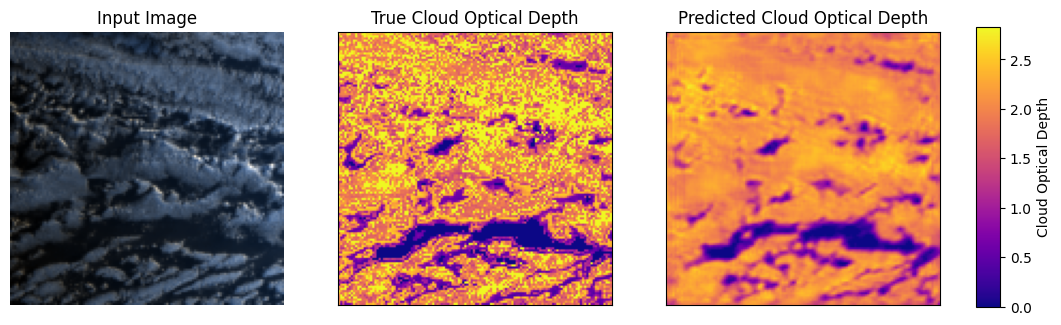

In [38]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

# Get the first batch
iterator = iter(test_loader)
images, labels = next(iterator)

# Move to device
images = images.to(device)
labels = labels.to(device)

# Unpack labels and predictions
_, _, cod_target, _ = unpack_labels(labels)
_, _, cod_pred, _ = model(images)

# Get first sample
img = images[idx].cpu().permute(1, 2, 0)
true_cod = cod_target[idx].cpu().squeeze().numpy()
pred_cod = cod_pred[idx].detach().cpu().squeeze().numpy()

# Extract ABI bands
blue = normalize(img[:, :, 0])  # Band 1
red = normalize(img[:, :, 1])   # Band 2
nir = normalize(img[:, :, 2])   # Band 3

# Simulate green using weighted combo (approx. true-color)
sim_green = (0.45 * red + 0.10 * nir + 0.45 * blue)
rgb_norm = torch.stack([red, sim_green, blue], dim=2).numpy()
#rgb_norm = torch.stack([red, nir, blue], dim=2).numpy()

# Determine shared color scale limits
vmin = min(true_cod.min(), pred_cod.min())
vmax = max(true_cod.max(), pred_cod.max())

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(rgb_norm)
axs[0].set_title("Input Image")
axs[0].axis('off')

im = axs[1].imshow(true_cod, cmap='plasma', vmin=vmin, vmax=vmax)
axs[1].set_title("True Cloud Optical Depth")
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(pred_cod, cmap='plasma', vmin=vmin, vmax=vmax)
axs[2].set_title("Predicted Cloud Optical Depth")
axs[2].set_xticks([])
axs[2].set_yticks([])

# Add colorbar on the right without shrinking images
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in figure coords
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Cloud Optical Depth')

plt.subplots_adjust(right=0.9)  # leave space for colorbar on right

plt.show()


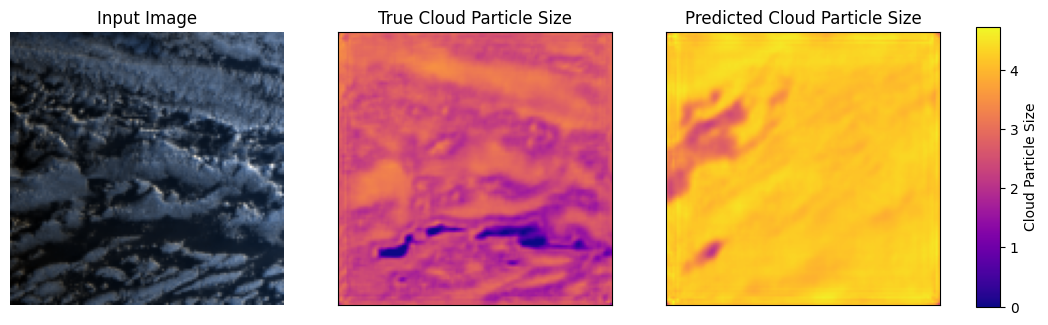

In [39]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

# Get the first batch
iterator = iter(test_loader)
images, labels = next(iterator)

# Move to device
images = images.to(device)
labels = labels.to(device)

# Unpack labels and predictions
_, _, _, cps_target = unpack_labels(labels)
_, _, _, cps_target = model(images)

# Get first sample
img = images[idx].cpu().permute(1, 2, 0)
true_cps = cps_target[idx].detach().cpu().squeeze().numpy()
pred_cps = cps_pred[idx].detach().cpu().squeeze().numpy()

# Extract ABI bands
blue = normalize(img[:, :, 0])  # Band 1
red = normalize(img[:, :, 1])   # Band 2
nir = normalize(img[:, :, 2])   # Band 3

# Simulate green using weighted combo (approx. true-color)
sim_green = (0.45 * red + 0.10 * nir + 0.45 * blue)
rgb_norm = torch.stack([red, sim_green, blue], dim=2).numpy()
#rgb_norm = torch.stack([red, nir, blue], dim=2).numpy()

# Determine shared color scale limits
vmin = min(true_cps.min(), pred_cps.min())
vmax = max(true_cps.max(), pred_cps.max())

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(rgb_norm)
axs[0].set_title("Input Image")
axs[0].axis('off')

im = axs[1].imshow(true_cps, cmap='plasma', vmin=vmin, vmax=vmax)
axs[1].set_title("True Cloud Particle Size")
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(pred_cps, cmap='plasma', vmin=vmin, vmax=vmax)
axs[2].set_title("Predicted Cloud Particle Size")
axs[2].set_xticks([])
axs[2].set_yticks([])

# Add colorbar on the right without shrinking images
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in figure coords
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Cloud Particle Size')

plt.subplots_adjust(right=0.9)  # leave space for colorbar on right

plt.show()
